## ReLU Units  
Stepped sigmoid units (SSU) for binomial units which represent N separate copies of a binary unit sharing the same bias and weights:
$$ \sum\limits^N_{i=1} σ(x − i + 0.5) \rightarrow \log(1 + e^x), \text{ as } N \rightarrow \infty$$
Extension to infinite number of copies gives the softplus unit:
$$h \sim \log(1 + e^x)=softplus(x)$$ for $x = v^T W + b$, where softplus can be approximated by a Noisy ReLU (NReLU) $$max(0, x + N(0, \sigma(x))$$ or ReLU $$max(0,x)$$  
For only N copies, the softplus becomes $$\log(1 + e^{x}) - \log(1 + e^{x-N})$$

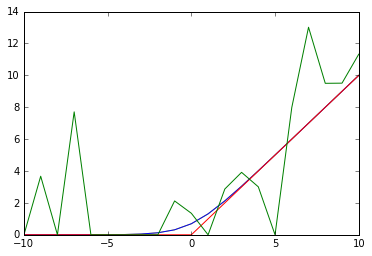

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(-10, 11)
plt.plot(x, np.log(1 + np.exp(x)), 'y', label='softplus')
plt.plot(x, np.log(1 + np.exp(x)) - np.log(1 + np.exp(x-len(x))), 'b', label='softplus')
plt.plot(x, np.maximum(0, x), 'r', label='ReLU')
plt.plot(x, np.maximum(0, x + np.random.randn(21)*np.std(x)), 'g', label='NReLU')

References:  
http://www.cs.toronto.edu/~fritz/absps/reluICML.pdf

In [301]:
import numpy as np
from theano import shared, function, tensor as T

In [304]:
batch_size = 20
num_vis = 15
num_hid = 5
num_slab = 10

## Spike-&-Slab RBM (ssRBM)

Parameters

In [305]:
v = T.fmatrix('v') # (batch_size, num_vis)
h = T.fmatrix('h') # (batch_size, num_hid)
s = T.fmatrix('s') # (batch_size, num_hid, num_slab)

W = shared(np.random.rand(num_vis, num_hid, num_slab), allow_downcast=True)
# diagonal matrices in form of vector, use T.linalg./np.diag for full matrix
Lambda = shared(np.random.rand(num_vis), allow_downcast=True)
alpha = shared(np.random.rand(num_hid, num_slab), allow_downcast=True)

Energy function:  
$$E(v, s, h) = {1 \over 2} v^T \Lambda v - \sum^N_{i=1} \left(v^T W_i s_i h_i - {1 \over 2} s_i^T \alpha_i s_i + b_i h_i \right)$$

Visible distribution:  
$$p(v, s, h) \propto \exp\left(- E(v, s, h)\right)$$  
$$p(v) \propto \sum_{h \in \{0,1\}} \int_{-\infty}^\infty \exp\left(- E(v, s, h)\right) \mathrm{d}s \\
= \int_{-\infty}^\infty \exp\left( - {1 \over 2} v^T \Lambda v \right) \prod_{i=1}^N \sum_{h_i \in \{0,1\}} \exp\left(v^T W_i s_i h_i - {1 \over 2} s_i^T \alpha_i s_i + b_i h_i \right) \mathrm{d}s \\  
= \exp\left( - {1 \over 2} v^T \Lambda v \right) \prod_{i=1}^N \sum_{h_i \in \{0,1\}} \exp\left( b_i h_i \right) \int_{-\infty}^\infty \exp\left(v^T W_i s_i h_i - {1 \over 2} s_i^T \alpha_i s_i \right) \mathrm{d}s \\ 
= \exp\left( - {1 \over 2} v^T \Lambda v \right) \prod_{i=1}^N \sum_{h_i \in \{0,1\}} \exp\left( b_i h_i \right) \int_{-\infty}^\infty \exp\left({1 \over 2} \left|\left| v^T W_i h_i \alpha_i^{-{1 \over 2}} \right|\right|^2\right) \exp\left( - {1 \over 2} \left|\left| x_i - v^T W_i h_i \alpha_i^{-{1 \over 2}} \right|\right|^2 \right) \mathrm{d}s \\ 
= \exp\left( - {1 \over 2} v^T \Lambda v \right) \prod_{i=1}^N \sum_{h_i \in \{0,1\}}\exp\left({1 \over 2} \left|\left| v^T W_i h_i \alpha_i^{-{1 \over 2}} \right|\right|^2 + b_i h_i \right) (2 \pi)^{{K \over 2}} det (\alpha_i^{-{1 \over 2}}) \\  
= \exp\left( - {1 \over 2} v^T \Lambda v \right) \prod_{i=1}^N \left[1 + \log\left({1 \over 2} v^T W_i \alpha_i^{-1} W_i^T v + b_i \right) \right] \prod_{i=1}^N \prod_{j=1}^K \left(2 \pi \alpha_{i, jj}^{-1} \right)^{{1 \over 2}}$$

Conditionals:
$$ p(h_i=1 | v) = \sigma\left({1 \over 2} v^T W_i \alpha_i^{-1} W_i^Tv + b_i \right) $$
$$ p(s | v, h) = \prod_{i=1}^N \mathcal{N} \left( h_i \alpha_i^{-1} W_i^Tv, \alpha_i^{-1} \right) $$
$$ p(v | s, h) = \mathcal{N} \left( \Lambda^{-1} \sum_{i=1}^N W_i s_i h_i, \Lambda^{-1} \right)$$

In [9]:
def sample_h_given_v(self, v):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... spike hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    sampling h ~ p(h_i=1|v) = sigm(0.5 v^TW_{i}\alpha_i^{-1}W_{i}^Tv + b_i)
    """
    vW = T.tensordot(v, self.W, axes=([1],[0])) # (batch_size, num_hid, num_slab)
    h_pre = 0.5 * T.sum(vW ** 2 / self.alpha.dimshuffle('x', 0, 1), axis=-1) + self.b # (batch_size, num_hid)
    h_mean = T.nnet.sigmoid(h_pre)
    h_samp = self.srng.binomial(size=h_mean.shape, n=1, p=h_mean,
                                dtype=theano.config.floatX)
    return [h_pre, h_mean, h_samp]

def sample_s_given_v_h(self, v, h):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... spike hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    s ... slab hidden of shape (batch_size, num_hid {N}, slab_dim {K})
    sampling s ~ p(s|v,h) = \Prod_{i=1}^N N(h_i \alpha_i^{-1}W^T_iv, \alpha_i^{-1})
    """
    vW = T.tensordot(v, self.W, axes=([1],[0])) # (batch_size, num_hid, num_slab)
    s_var = self.alpha.dimshuffle('x', 0, 1)
    s_mean = s_pre = (h.dimshuffle(0, 1, 'x') / s_var) *  vW
    samp = self.srng.normal(size=s_mean.shape, dtype=theano.config.floatX) # mean-field approximation
    s_samp = samp / T.sqrt(s_var) + s_mean
    return [s_pre, s_mean, s_samp]

def sample_v_given_s_h(self, s, h):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... spike hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    s ... slab hidden of shape (batch_size, num_hid {N}, slab_dim {K})
    sampling s ~ p(s|v,h) = \Prod_{i=1}^N N(h_i \alpha_i^{-1}W^T_iv, \alpha_i^{-1})
    """
    # hs ~ (batch_size, num_hid, 'x') * (batch_size, num_hid, slab_dim) = (batch_size, num_hid, num_slab)
    # v_pre ~ (batch_size, 'x', num_hid, num_slab) * ('x', num_vis, num_hid, num_slab) = (batch_size, num_vis, num_hid, num_slab)
    Wsh = T.tensordot(h[:,:,None] * s, self.W, axes=([1,2], [1,2])) # (batch_size, num_vis) T.sum(hs[:,None] * self.W[None], axis=(2,3))
    v_var = self.Lambda
    v_mean = v_pre = Wsh / v_var # (batch_size, num_vis) / diag(num_vis,) = (batch_size, num_vis)
    samp = self.srng.normal(size=v_mean.shape, dtype=theano.config.floatX)
    v_samp = samp / T.sqrt(s_var) + v_mean
    return [v_pre, v_mean, v_samp]

Free energy:
$$ F(v) = - \log(p(v)) \\  
\propto {1 \over 2} v^T \Lambda v - \sum_{i=1}^N \log \left (1 + \exp\left({1 \over 2} v^T W_i \alpha_i^{-1} W_i^T v + b_i \right) \right) - {1 \over 2} \sum_{i=1}^N \sum_{j=1}^K \log (2 \pi \alpha_{i, jj}^{-1}) + \log Z \\
= {1 \over 2} v^T \Lambda v - \sum_{i=1}^N softplus \left ({1 \over 2} v^T W_i \alpha_i^{-1} W_i^T v + b_i \right) - {1 \over 2} \sum_{i=1}^N \sum_{j=1}^K \log (2 \pi \alpha_{i, jj}^{-1}) + \log Z$$

In [10]:
def free_energy_spike_n_slab(self, v):
    fe_vis_term = 0.5 * T.dot(v ** 2, self.Lambda) # T.sum((v ** 2) * self.L, axis=-1) # (batch_size, num_vis) x (num_vis,) = (batch_size,)
    fe_vW_sqr = T.tensordot(v, self.W, axes=([1],[0])) ** 2 # (batch_size, num_hid, num_slab)
    fe_hid_pre = 0.5 * T.sum(vW_sqr / self.alpha[None], axis=-1) + self.b
    
    # T.log(1 + T.exp(fe_hid_pre)).sum(axis=-1)
    fe_hid_term = T.nnet.softplus(fe_hid_pre).sum(axis=1) # (batch_size,...)
    
    const_term = 0.5 * T.log(2 * np.pi * self.alpha).sum() # sum over num_hid and num_slab (diagonals)
    return fe_vis_term - fe_hid_term - const_term

## $\mu$-Spike-&-Slab RBM ($\mu$-ssRBM)

In [ ]:
v = T.fmatrix('v') # (batch_size, num_vis)
h = T.fmatrix('h') # (batch_size, num_hid)
s = T.fmatrix('s') # (batch_size, num_hid, num_slab)

W = shared(np.random.rand(num_vis, num_hid, num_slab), allow_downcast=True)
# diagonal matrices in form of vector, use T.linalg./np.diag for full matrix
Lambda = shared(np.random.rand(num_vis), allow_downcast=True)
alpha = shared(np.random.rand(num_hid, num_slab), allow_downcast=True)

Phi = shared(np.random.rand(num_hid, num_vis), allow_downcast=True) # (num_hid, num_vis) -> diag in num_vis
mu = shared(np.random.rand(num_hid, num_slab), allow_downcast=True) # (num_hid, num_slab)

Energy function:  
$$E(v, s, h) = {1 \over 2} v^T \left( \Lambda + \sum_{i=1}^N \Phi_i h_i \right) v - \sum^N_{i=1} \left(v^T W_i s_i h_i - {1 \over 2} s_i^T \alpha_i s_i + b_i h_i \right) - \sum_{i=1}^N  \mu_i^T \alpha_i s_i h_i - \sum_{i=1}^N \mu_i^T \alpha_i \mu_i h_i$$

Visible distribution:  
$$p(v, s, h) \propto \exp\left(- E(v, s, h)\right)$$  
Following above derivation:  
$$p(v) \propto \sum_{h \in \{0,1\}} \int_{-\infty}^\infty \exp\left(- E(v, s, h)\right) \mathrm{d}s \\
= \exp\left( - {1 \over 2} v^T \Lambda v \right) \prod_{i=1}^N \left[1 + \log\left(-{1 \over 2} v^T C_{v|h_i}^{-1} v + v^T W_i \mu_i + b_i \right) \right] \prod_{i=1}^N \prod_{j=1}^K \left(2 \pi \alpha_{i, jj}^{-1} \right)^{{1 \over 2}}$$

Conditionals:

$$ p(h_i=1 | v) = \sigma\left({1 \over 2} v^T W_i \alpha_i^{-1} W_i^Tv + v^TW_i \mu_i - {1 \over 2} v^T\Phi_i v + b_i \right) $$
$$ p(s | v, h) = \prod_{i=1}^N \mathcal{N} \left( (v^TW_i\alpha_i^{-1} + \mu_i) h_i, \alpha_i^{-1} \right) $$
$$ p(v | s, h) = \mathcal{N} \left( C_{v|s,h}\sum_{i=1}^N W_i s_i h_i, C_{v|s,h} ) \right), \quad C_{v|s,h} = \left(\Lambda + \sum_{i=1}^N \Phi_i h_i\right)^{-1}$$

In [106]:
def sample_h_given_v(self, v):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... spike hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    sampling h ~ p(h_i=1|v) = sigm(0.5 v^TW_{i}\alpha_i^{-1}W_{i}^Tv + b_i)
    """
    vW = T.tensordot(v, self.W, axes=([1],[0])) # (batch_size, num_vis) x (num_vis, num_hid, num_slab) = (batch_size, num_hid, num_slab)
    vW_sqr_b = 0.5 * T.sum(vW ** 2 / self.alpha[None], axis=-1) + self.b # (batch_size, num_hid)
    vW_mu = T.sum(vW * self.mu.dimshuffle('x', 0, 1), axis=-1) # (batch_size, num_hid, num_slab) x ('x', num_hid, num_slab) = (batch_size, num_hid)
    vPhiv = 0.5 * T.dot(v ** 2, self.Phi.T) # (batch_size, num_vis) x (num_vis, num_hid) = (batch_size, num_hid)
    h_pre = vW_sqr_b + vW_mu - vPhiv
    h_mean = T.nnet.sigmoid(h_pre)
    h_samp = self.srng.binomial(size=h_mean.shape, n=1, p=h_mean,
                                dtype=theano.config.floatX)
    return [h_pre, h_mean, h_samp]

def sample_s_given_v_h(self, v, h):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... spike hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    s ... slab hidden of shape (batch_size, num_hid {N}, slab_dim {K})
    sampling s ~ p(s|v,h) = \Prod_{i=1}^N N(h_i \alpha_i^{-1}W^T_iv, \alpha_i^{-1})
    """
    vW = T.tensordot(v, self.W, axes=([1],[0])) # (batch_size, num_hid, num_slab)
#     s_pre = (h.dimshuffle(0, 1, 'x') / self.alpha.dimshuffle('x', 0, 1)) *  vW
    # (batch_size, num_hid, 'x') / ('x', num_hid, num_slab) = (batch_size, num_hid, num_slab)
    s_var = self.alpha.dimshuffle('x',0)
    s_mean = s_pre = h * (vW / s_var + self.mu.dimshuffle('x',0)) #  (batch_size, num_hid, num_slab) + ('x', num_hid, num_slab)
    # mean-field approximation
    samp = self.srng.normal(size=s_mean.shape, dtype=theano.config.floatX)
    s_samp = samp / T.sqrt(s_var) + s_mean
    return [s_pre, s_mean, s_samp]

def sample_v_given_s_h(self, s, h):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... spike hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    s ... slab hidden of shape (batch_size, num_hid {N}, slab_dim {K})
    sampling s ~ p(s|v,h) = \Prod_{i=1}^N N(h_i \alpha_i^{-1}W^T_iv, \alpha_i^{-1})
    """
    # hs ~ (batch_size, num_hid, 'x') * (batch_size, num_hid, slab_dim) = (batch_size, num_hid, num_slab)
    # v_pre ~ (batch_size, 'x', num_hid, num_slab) * ('x', num_vis, num_hid, num_slab) = (batch_size, num_vis, num_hid, num_slab)
    C = self.Lambda + T.dot(h, self.Phi) # (num_vis,) + (batch_size, num_hid) x (num_hid, num_vis) = (batch_size, num_vis)
    Wsh = T.tensordot(h.dimshuffle(0,1,'x') * s, self.W, axes=([1,2], [1,2])) # (batch_size, num_vis) # T.sum(hs[:,None] * self.W[None], axis=(2,3))
    v_mean = v_pre = Wsh / C # (batch_size, num_vis) / [batch_size, diag(num_vis,)] = (batch_size, num_vis)
    samp = self.srng.normal(size=v_mean.shape, dtype=theano.config.floatX)
    v_samp = samp / T.sqrt(C) + v_mean
    return [v_pre, v_mean, v_samp]

Free energy:  
$$ F(v) = - \log(p(v)) \\  
= {1 \over 2} v^T \Lambda v - \sum_{i=1}^N \log \left (1 + \exp\left(-{1 \over 2} v^T C_{v|h_i}^{-1} v + v^T W_i \mu_i + b_i \right) \right) - {1 \over 2} \sum_{i=1}^N \sum_{j=1}^K \log (2 \pi \alpha_{i, jj}^{-1}) + \log Z \\
= {1 \over 2} v^T \Lambda v - \sum_{i=1}^N softplus \left (-{1 \over 2} v^T C_{v|h_i}^{-1} v + v^T W_i \mu_i + b_i \right) - {1 \over 2} \sum_{i=1}^N \sum_{j=1}^K \log (2 \pi \alpha_{i, jj}^{-1}) + \log Z \\
C_{v|h_i}^{-1} = \left(\Phi_i - W_i \alpha_i^{-1}W_i^T\right)$$

In [105]:
def free_energy_mu_spike_n_slab(self, v):
    fe_vis_term = 0.5 * T.dot(v ** 2, self.Lambda) # (batch_size, num_vis) x (num_vis,) = (batch_size,...)
    
    fe_vW = T.tensordot(v, self.W, axes=([1],[0])) # (batch_size, num_vis) x (num_vis, num_hid, num_slab) = (batch_size, num_hid, num_slab)
    fe_vW_sqr_b = 0.5 * T.sum(vW ** 2 / self.alpha.dimshuffle('x',0), axis=-1) + self.b # (batch_size, num_hid)
    fe_vW_mu = T.sum(vW * self.mu.dimshuffle('x', 0, 1), axis=-1) # (batch_size, num_hid, num_slab) x ('x', num_hid, num_slab) = (batch_size, num_hid)
    fe_vPhiv = 0.5 * T.dot(v ** 2, self.Phi.T) # (batch_size, num_vis) x (num_vis, num_hid) = (batch_size, num_hid)
    fe_hid_pre = = vW_sqr_b + vW_mu - vPhiv # (batch_size, num_hid)
    
    fe_hid_term = T.nnet.softplus(fe_hid_pre).sum(axis=1) # (batch_size,...) # T.log(1 + T.exp(fe_hid_pre)).sum(axis=-1)
    
    fe_const_term = 0.5 * T.log(2 * np.pi * self.alpha).sum()
    return fe_vis_term - fe_hid_term - const_term

## Mean-Covariance RBM (mcRBM)

In [ ]:
C = shared(np.random.rand(num_vis, num_filt), allow_downcast=True)
P = shared(np.random.rand(num_filt, num_hid_c), allow_downcast=True)
W = shared(np.random.rand(num_vis, num_hid_m), allow_downcast=True)
b_c = shared(np.random.rand(num_hid_c,), allow_downcast=True)
b_m = shared(np.random.rand(num_hid_m,), allow_downcast=True)

v = T.fmatrix('v') # (batch_size, num_vis)
h_m = T.fmatrix('h_m') # (batch_size, num_hid_m)
h_c = T.fmatrix('h_c') # (batch_size, num_hid_c)

* needs a HMC sampler instead of the Gibb's one
* needs to solve batchwise system of linear equations to evaluate batchwise matrix inversion

In [ ]:
import sys
sys.path.append('/home/adrian/code/theano_wmf/')
from theano_wmf import ops

from theano.tensor.slinalg import solve as Tsolve
from theano.tensor.nlinalg import pinv as Tpinv
from scipy.linalg import solve, pinv
import theano

In [ ]:
S = T.ftensor3('S')
Wh = T.fmatrix('Wh')

In [ ]:
def batch_solve_expression(A_batch, B_batch):
    Ainv_batch = ops.batched_inv(A_batch)
    R_batch = ops.batched_dot(Ainv_batch, B_batch) # .dimshuffle(0,1,'x')) # need to turn the A vectors into single-row matrices for this
    return R_batch # [:, :, 0] 

Tsolve = theano.function([S, Wh], batch_solve_expression(S, Wh[:,:,None])[:,:,0], allow_input_downcast=True)

In [ ]:
%%time
theano_res = Tsolve(np.random.rand(100,500,500), np.random.rand(100,500))

In [ ]:
%%time
theano_res2 = Tsolve(np.random.rand(20,784,784), np.random.rand(20,784))

Energy function:  
$$ E^{mc}(v, h^c, h^m) = E^{c}(v, h^c) + E^m(v, h^m)$$  
$$ E^{c}(v, h^c) = - {1 \over 2} \left({v^T \over \| v \|} C \text{ diag }\left(\{\| C_{:,k} \|\}_{k=1}^N\right)^{-1}\right)^2 P h^c  - b_c^T h^c + {1 \over 2} v^Tv$$
$$ E^m(v, h^m) = - v^TWh^m - v^Tb_m$$  

Visible distribution:  
$$p(v, h^c, h^m) \propto \exp\left(- E(v, h^c, h^m)\right)$$  
$$ p(v) \propto \sum\limits_{h^c, h^m} \exp\left(- E(v, h^c, h^m) \right) $$

Conditionals:  
$$ p(h^m | v) = \sigma\left( v^T W + b_v \right ) $$
$$ p(h^c | v) = \sigma\left( {1 \over 2} \left({v^T \over \| v \|} C \text{ diag }\left(\{\| C_{:,k} \|\}_{k=1}^N\right)^{-1}\right)^2 P + b_c - {1 \over 2} v^T v\right)$$
$$ p(v | h^m, h^c) = N\left(\Sigma (W h^c), \Sigma \right), \quad \Sigma = C \text{ diag } (P h^c) C^T)^{-1}$$

In [ ]:
def sample_hm_given_v(self, v):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    sampling h ~ p(h_i=1|v) = sigm(0.5 v^TW_{i}\alpha_i^{-1}W_{i}^Tv + b_i)
    """
    h_pre = v.dot(self.W) + self.b_m # (batch_size, num_hid_m)
    h_mean = T.nnet.sigmoid(h_pre)
    h_samp = self.srng.binomial(size=h_mean.shape, n=1, p=h_mean,
                                dtype=theano.config.floatX)
    return [h_pre, h_mean, h_samp]

def sample_hc_given_v(self, v):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... spike hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    sampling h ~ p(h_i=1|v) = sigm(0.5 v^TW_{i}\alpha_i^{-1}W_{i}^Tv + b_i)
    """
    h_pre = 0.5 * (v.dot(self.C)**2).dot(self.P) + self.b_c # (batch_size, num_hid_c)
    h_mean = T.nnet.sigmoid(h_pre)
    h_samp = self.srng.binomial(size=h_mean.shape, n=1, p=h_mean,
                                dtype=theano.config.floatX)
    return [h_pre, h_mean, h_samp]

def sample_v_given_hm_hc(self, h_m, h_c):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... spike hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    s ... slab hidden of shape (batch_size, num_hid {N}, slab_dim {K})
    sampling s ~ p(s|v,h) = \Prod_{i=1}^N N(h_i \alpha_i^{-1}W^T_iv, \alpha_i^{-1})
    """
    hP = h_c.dot(self.P.T)[:,None] # (batch_size, num_hid_c) x (num_hid_c, num_filt) = (batch_size, 'x', num_filt)
    # [('x', num_vis, num_filt) * (batch_size, 'x', num_filt)] x (num_filt, num_vis) 
    Sigma = T.tensordot(self.C[None] * hP, self.C.T, axes=([-1], [0])) # (batch_size, num_vis, num_vis)
    Wh_m = T.dot(h_m, self.W.T) # (batch_size, num_vis)
    v_mean = v_pre = Tsolve(Sigma, Wh_m[:,:,None])[:,:,0] # (batch_size, num_vis, ...)
    samp = self.srng.normal(size=v_mean.shape, dtype=theano.config.floatX)
    v_samp = Tsolve(T.sqrt(Sigma), samp[:,:,None])[:,:,0] + v_mean 
    return [v_pre, v_mean, v_samp]

Free energy:  
$$ F(v) = - \log p(v) = − \sum\limits_{k} \log\left(1 + \exp\left( {1 \over 2} (v^T C_{:,k})^2 P \right) + b^c_k \right) −
\sum\limits_{j} \log\left(1 + \exp\left(v^T W_{:,j} + b^m_j \right) \right) $$

Authors description of the HMC sampling procedure:  
"HMC draws a sample by simulating a particle moving on
this free energy surface. The particle starts at the data-point
and is given an initial random momentum sampled from a
spherical Gaussian with unit variance. It then moves over
the surface using the gradient of the free energy to determine
its acceleration. If the simulation is accurate, the sum
of the potential and kinetic energies will not change and the
results of the simulation can be accepted. If the total energy
rises during the simulation, the result is accepted with
a probability equal to the negative exponential of the total
energy increase. Numerical errors can be reduced by using
“leapfrog” steps. After simulating the trajectory
for a number of leapfrog steps, the current momentum
is discarded and a new momentum is sampled from a spherical
Gaussian. This Markov chain will eventually sample
from the correct distribution, but we only need to run it for
a small fraction of the time this would take."

In [ ]:
def free_energy_mean(self, v):
    fe_m_pre = v.dot(self.W) + self.b_m
    return - T.sum(T.softplus(fe_m_pre), axis=-1) # (batch_size,)

def free_energy_cov(self, v):
    v_norm = T.sum(v**2, axis=-1)
    C_norm = T.sum(self.C**2)
    C_normed = C / C_norm
    v_normed = v / v_norm
    fe_c_pre = 0.5 * (v_normed.dot(C_normed)**2).dot(self.P) + self.b_c + 0.5 * v_norm
    return - T.sum(T.softplus(fe_c_pre), axis=-1) # (batch_size,)

def free_energy(self, v):
    fe_m_term = self.free_energy_mean(v)
    fe_c_term = self.free_energy_cov(v)
    return fe_c_term + fe_m_term

The algorithm:  
1) compute the gradient of the free energy at the training samples  
2) get samples by using CD with HMC  
3) compute the gradient of the free energy at the HMC samples  
4) update the parameters by taking the difference of the gradients

References:  
http://www.cs.toronto.edu/~fritz/absps/ranzato_cvpr2010.pdf

## Mean Product of Student t's (mPoT)

In [15]:
C = shared(np.random.rand(num_vis, num_hid_c))
W = shared(np.random.rand(num_vis, num_hid_m))
gamma = shared(np.zeros(num_hid_c,))

Energy function:  
$$ E^{mPoT}(v, h^c, h^m) = E^{PoT}(v, h^c) + E^m(v, h^m)$$  
$$ E^{PoT}(v, h^c) = \left(1 + {1 \over 2}(v^T C)^2\right)P h^c + (1-\gamma)^T\log h^c$$
$$ E^m(v, h^m) = {1 \over 2} v^Tv - v^TWh^m - b^T_m h^m - v^T b_v$$  

Visible distribution (recipe for extending any distribution by including hidden variables):  
$$ p(v, h^c, h^m) \propto \exp\left(-E^{mPoT}(v, h^c, h^m) \right) $$  
$$ p(v) \propto \left( 1 + {1 \over 2} (v^T C)^2 \right)^{-\gamma} = \exp \left( -\log(1 + {1 \over 2} (v^T C)^2)^T \gamma \right) \\ 
= \sum_{h^m \in \{0,1\}^N} \int_{-\infty}^\infty \exp\left(-E^{mPoT}(v, h^c, h^m) \right) \mathrm{d}h^c$$

Conditionals:  
$$ p(h^m | v) = \sigma(v^T W + b_m)$$
$$ p(h^c | v) = \Gamma \left(\alpha=\gamma, \beta=1 + {1 \over 2} (v^T C)^2 P \right) 
=> E[h^c | v] = {\alpha \over \beta} = {\gamma \over 1 + {1 \over 2} (v^T C)^2 P}$$
$$ p(v | h^m, h^c) = N \left( \Sigma(W h^m + b_v), \Sigma \right), \quad \Sigma^{-1} = C \text{ diag } (P h^c) C^T$$

Free energy:
$$ F(v) = - \log p(v) = \sum\limits^N_{j=1} \log\left(1 + {1 \over 2} \left(v^T C \right)^2 P_{:,j} \right) + {1 \over 2} v^T v - \sum\limits^M_{k=1} \log\left(1 + \exp\left(v^T W_{:,k} + b^m_{k} \right) \right) - v^Tb_v$$

In [20]:
# HMC sampling:  
def draw_sample(datainit, param, layer): # only 1 M.C. step
    if layer == 1: # 1st layer: do 1 step of HMC
        velocity = np.random.randn()
        tot_energy1 = .5*velocity**2 + compute_F(datainit,param)
        data = datainit
        velocity = velocity - eps * compute_dFdX(data,param)/2
        for iter in range(20): # 20 leap-frog steps
            data = data + eps * velocity
            if iter != 19:
                velocity = velocity - eps * compute_dFdX(data,param)
        velocity = velocity - eps * compute_dFdX(data,param)
        tot_energy2 = .5*velocity**2 + compute_F(data,param)
        if rand() < exp(tot_energy1 - tot_energy2):
            return data # accept sample
        else:
            return datainit # reject sample
    else: # higher layers: do 1 step of Gibbs
        hiddens = sample_posterior(datainit,param) # p(h|x)
        return sample_inputs(hiddens,param) # p(x|h)

Reference:  
http://www.cs.toronto.edu/~fritz/absps/PoT.pdf (PoT)  
http://www.cs.toronto.edu/~fritz/absps/mcimage.pdf  
https://www.cs.toronto.edu/~vmnih/docs/ranzato_pami13.pdf (extended version)

## Gamma sampler

https://github.com/benanne/morb/blob/master/morb/samplers.py  
https://groups.google.com/forum/#!topic/theano-users/ytqep8AickA

In [223]:
## approximate gamma sampler
# Two approximations for the gamma function are defined.
# Windschitl is very fast, but problematic close to 0, and using the reflection formula
# causes discontinuities.
# Lanczos on the other hand is extremely accurate, but slower.
   
def _log_gamma_windschitl(z):
    """
    computes log(gamma(z)) using windschitl's approximation.
    """
    return 0.5 * (T.log(2*np.pi) - T.log(z)  + z * (2 * T.log(z) - 2 + T.log(z * T.sinh(1/z) + 1 / (810*(z**6)))))
    
def _log_gamma_ratio_windschitl(z, k):
    """
    computes log(gamma(z+k)/gamma(z)) using windschitl's approximation.
    """
    return _log_gamma_windschitl(z + k) - _log_gamma_windschitl(z)
    

def _log_gamma_lanczos(z):
    # optimised by nouiz. thanks!
    assert z.dtype.startswith("float")
    # reflection formula. Normally only used for negative arguments,
    # but here it's also used for 0 < z < 0.5 to improve accuracy in
    # this region.
    flip_z = 1 - z
    # because both paths are always executed (reflected and
    # non-reflected), the reflection formula causes trouble when the
    # input argument is larger than one.
    # Note that for any z > 1, flip_z < 0.
    # To prevent these problems, we simply set all flip_z < 0 to a
    # 'dummy' value. This is not a problem, since these computations
    # are useless anyway and are discarded by the T.switch at the end
    # of the function.
    flip_z = T.switch(flip_z < 0, 1, flip_z)
    log_pi = np.asarray(np.log(np.pi), dtype=z.dtype)
    small = log_pi - T.log(T.sin(np.pi * z)) - _log_gamma_lanczos_sub(flip_z)
    big = _log_gamma_lanczos_sub(z)
    return T.switch(z < 0.5, small, big)


def _log_gamma_lanczos_sub(z): # expanded version
    # optimised by nouiz. thanks!
    # Coefficients used by the GNU Scientific Library
    # note that vectorising this function and using .sum() turns out to be
    # really slow! possibly because the dimension across which is summed is
    # really small.
    g = 7
    p = np.array([0.99999999999980993, 676.5203681218851, -1259.1392167224028,
                  771.32342877765313, -176.61502916214059, 12.507343278686905,
                  -0.13857109526572012, 9.9843695780195716e-6,
                  1.5056327351493116e-7], dtype=z.dtype)
    z = z - 1
    x = p[0]
    for i in range(1, g + 2):
        x += p[i] / (z + i)
    t = z + g + 0.5
    pi = np.asarray(np.pi, dtype=z.dtype)
    log_sqrt_2pi = np.asarray(np.log(np.sqrt(2 * np.pi)), dtype=z.dtype)
    return log_sqrt_2pi + (z + 0.5) * T.log(t) - t + T.log(x)

    
def _log_gamma_ratio_lanczos(z, k):
    """
    computes log(gamma(z+k)/gamma(z)) using the lanczos approximation.
    """ 
    return _log_gamma_lanczos(z + k) - _log_gamma_lanczos(z)
    
 
def gamma_approx(k, theta=1):
    """
    Sample from a gamma distribution using the Wilson-Hilferty approximation.
    The gamma function itself is also approximated, so everything can be
    computed on the GPU (using the Lanczos approximation).
    """
    lmbda = 1/3.0 # according to Wilson and Hilferty
    mu = T.exp(_log_gamma_ratio_lanczos(k, lmbda))
    sigma = T.sqrt(T.exp(_log_gamma_ratio_lanczos(k, 2*lmbda)) - mu**2)
    normal_samples = theano_rng.normal(size=k.shape, avg=mu, std=sigma, dtype=theano.config.floatX)
    gamma_samples = theta * T.abs_(normal_samples ** 3)
    # The T.abs_ is technically incorrect. The problem is that, without it, this formula may yield
    # negative samples, which is impossible for the gamma distribution.
    # It was also noted that, for very small values of the shape parameter k, the distribution
    # of resulting samples is roughly symmetric around 0. By 'folding' the negative part
    # onto the positive part, we still get a decent approximation because of this.
    return gamma_samples

In [ ]:
def sample_hm_given_v(self, v):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    sampling h ~ p(h_i=1|v) = sigm(0.5 v^TW_{i}\alpha_i^{-1}W_{i}^Tv + b_i)
    """
    h_pre = v.dot(self.W) + self.b_m # (batch_size, num_hid_m)
    h_mean = T.nnet.sigmoid(h_pre)
    h_samp = self.srng.binomial(size=h_mean.shape, n=1, p=h_mean,
                                dtype=theano.config.floatX)
    return [h_pre, h_mean, h_samp]

def sample_hc_given_v(self, v):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h ... spike hidden of shape (batch_size, num_hid {N}, spike_dim {1}) => (batch_size, num_hid {N})
    sampling h ~ p(h_i=1|v) = sigm(0.5 v^TW_{i}\alpha_i^{-1}W_{i}^Tv + b_i)
    """
    # Gamma sampler
    alpha = self.gamma # (num_hid_c,)
    beta = 1 + 0.5 * (v.dot(C)**2) # (batch_size, num_hid_c)
    k = alpha
    theta = 1 / beta
    h_mean = k * theta # alpha / beta
    h_samp = gamma_approx(k, theta) # k == alpha, theta == 1/beta
    return [None, h_mean, h_samp]

def sample_v_given_hm_hc(self, h_m, h_c):
    """
    v ... visible of shape (batch_size, num_vis {D})
    h_m ... mean hidden of shape (batch_size, num_hid {N})
    h_c ... cov hidden of shape (batch_size, num_hid {N})
    sampling v ~ p(v|h_m,h_c) = 
    """
    ChC = T.tensordot(self.C[None] * h_c[:,None], self.C.T, axes=([-1], [0])) 
    # ('x', num_vis, num_hid_c) * (batch_size, 'x', diag(num_hid_c)) x (num_hid_c, num_vis) = (batch_size, num_vis, num_vis)
    Sigma_c = theano.scan(lambda x: T_inv(x), ChC) 
    Sigma = Sigma_c + T.eye(m=C.shape[0])[None] # (batch_size, num_vis, num_vis)
    Wh_m = T.dot(h_m, self.W.T) # (batch_size, num_hid_m) x (num_hid_m, num_vis) = (batch_size, num_vis)
    v_mean = v_pre = Tsolve(Sigma, Wh_m[:,:,None])[:,:,0] # (batch_size, num_vis, ...)
    # (batch_size, num_vis, num_vis)^-1 x (batch_size, num_vis, 'x') = (batch_size, num_vis)
    samp = self.srng.normal(size=v_mean.shape, dtype=theano.config.floatX)
    v_samp = Tsolve(T.sqrt(Sigma), samp[:,:,None])[:,:,0] + v_mean 
    return [v_pre, v_mean, v_samp]

In [ ]:
def free_energy_pot_mean(self, v):
    fe_m_pre = v.dot(self.W) + self.b_m
    return - T.sum(T.softplus(fe_m_pre), axis=-1) # (batch_size,)

def free_energy_pot_cov(self, v):
    v_norm = T.sum(v**2, axis=-1) # (batch_size,)
    fe_c_pre = 1 + 0.5 * (v.dot(C)**2) # (batch_size, num_hid_c)
    return T.sum(T.log(fe_c_pre) * self.gamma, axis=-1) + 0.5 * v_norm # (batch_size,)

def free_energy(self, v):
    fe_m_term = self.free_energy_mean(v)
    fe_c_term = self.free_energy_cov(v)
    return fe_c_term + fe_m_term